# Well Fluid Rate Prediction Using Machine Learning/Deep Learning Models

Gulf of Suez Petroleum company (GUPCO) is one of the largest brownfields in Egypt since 1965. The company main concessions are in Ras Shukier field which comprises numerous producer and injector wells. Most of producer wells are gas lift wells with small percent of natural flow and ESP wells. The field has a giant network of offshore/onshore pipelines connecting satellite platforms to central complex platforms for 1) gathering production from connected wells, 2) primary separating gas/fluid streams, 3) compressing gas lift using several huge compressor modules to be injected again in producer wells and 4) testing each well using test separators installed in central complex platforms, from where the fluid stream is then sent to onshore units for secondary separation and processing.

Regular testing of producer wells is a crucial task in the company since most of the wells are producing by the available gas lift in the network. Therefore, wells testing is considered the main key for optimizing injection gas for each well, prioritizing on stream wells, having high oil production per 1 MMSCFD gas lift, in order to maximize the total oil production and calculating company's revenues in accurate way when back allocating daily oil production to each concession. Physical well testing devices used in the field involve complex test separators, portable test separator and multi-phase flow meters. However, testing this enormous number of producer wells using physical devices only is considered one of the major challenges in the field due to the following reasons:
-	Most of testing separators and pipelines are old and out of services due to technical operating problems.
-	Logistics and weather difficulties limiting the flexibility of installing/backloading the portable test separator in offshore platforms.
-	Multi phase flow meter is installed only in main vital platforms due to its high capital/operating cost.

Consequently to overcome the above difficulties, virtual testing techniques, either physics driven or data driven, become a fundamental alternate to other testing techniques. Physics driven model as Prosper and Pipesim software are commonly used for estimating wells fluid rate, but these models have some shortcomings including the relatively long time consumed to build well or entire field network, the high sensitivity of prediction error to input model variables and the uncertainty of the input recorded data.

In this notebook, a new data driven model is introduced to overcome the previous shortcomings of physical and virtual testing methods. The model is based on machine learning/deep learning methods, where the model shows outstanding simplicity and applicability in only few seconds for predicting fluid rate with relatively high accuracy compared to the commonly used methods in the company.
The applied steps for building the model are summarized as following:
1.  Analyzing General Energy Equation for fluid mechanics to select the relevant inputs
2.  Filtering the selected inputs according to the availability of actual recorded data
3.  Collecting sample of data from the company database to run prototype model
4.  Selecting important features using three different approaches
5.  Collecting new data only for selected features
6.  Exploring the data variables using Exploratory Data Analysis (EDA)
7.  Feature Engineering
8.  Comparing the results of different machine learning models and selecting the best model
9.  Optimizing the model by hyperparameters fine tuning
10. Developing a deep learning model and comparing the results
11. Deploying the models using Streamlit app

### 1. Analyzing General Energy Equation for fluid mechanics to select the relevant inputs

The General Energy Equation describes the conservation of energy. The equation states that the change in energy between two points along a flowing fluid is equal to the work done on the fluid minus any energy loss. If there is no work done on the fluid, the General Energy Equation can be used to describe the pressure loss along a flow path as following:

[dp/dl] = g/g_c ρsinθ + [dp/dl]_f + ρυdυ/(g_c dl)  

Where:

[dp/dl]: Total pressure drop, psi/ft,

g/g_c ρsinθ    : Elevation pressure drop, psi/ft,

[dp/dl]_f      : Friction pressure drop, psi/ft,

ρυdυ/(g_c dl)  : Acceleration pressure drop, psi/ft.


In order to determine the main variables affecting pressure drop between bottomhole and wellhead and hence affecting fluid rate, the General Energy Equation is further decomposed into the main variables affecting three phase flow along the wellbore.

- Gas gravity
- Oil gravity
- Water gravity
- deviation angle
- Wellhead pressure
- Wellhead temperature
- Bottomhole flowing pressure
- Bottomhole flowing temperature
- Wellbore diameter
- Watercut percent
- Injection gas
- Downstream pressure
- Solution gas/oil ratio

### 2. Filtering the selected inputs according to the availability of actual recorded data

The next step was to select the input variables for the machine learning model. In doing so, the variables obtained from the General Energy Equation are compared with the actual available data in select the final input variables and try to find alternates for the missing ones as following:

- Gas gravity
- Oil API
- Water gravity
- Tubing end depth
- Tubing end to top perforation
- Tubing type (Normal - Big bore - Slim)
- Liner diameter
- Measured depth to top perforation
- True vertical depth to top perforation
- Wellhead pressure
- Wellhead temperature
- Reservoir temperature (1)
- Reservoir Pressure (2)
- Bubble point pressure
- difference between reservoir pressure and bubble point
- Watercut percent
- Injection gas
- Downstream pressure
- Solution gas/oil ratio
- Reservoir type

(1) Reservoir temperature is used as an alternate to bottomhole temperature as the reservoir is assumed to be isothermal.

(2) Reservoir pressure is used as an alternate to bottomhole pressure as the latter is not recorded continuously and cannot be interpolated unlike reservoir pressure.

### 3. Collecting sample of data from the company database to run prototype model

The next step was to collect a sample of well test data to check model performance and select the features affecting the model accuracy.

A sample of 1783 well tests is collected from 28 gas lift wells with all the variables mentioned above.

In [1]:
#Importing the related libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.inspection import permutation_importance
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
sb.set()

In [2]:
#Importing the data sample

data_sample = pd.read_csv('Sample wells.csv')
data_sample.head(3)

,WHP,WHT,tbg end depth\n(ORKB),tbg end to top perf.,liner size,MD\n(top perf.),TVD\n(top perf.),Tr,Rsb,API,...,Pr,Pr-Pb,WC%,IG (MMCFD),D/S,tbg type,Reservoir,BFPD,BOPD,GG
0,125,163,10375,555,7,10930,10912,250,279,21.8,...,2715,1032,86,3.2,1330,Normal,Nubia,2844,398,3.3
1,123,163,10375,555,7,10930,10912,250,279,21.8,...,2715,1032,87,3.2,1332,Normal,Nubia,2700,351,3.4
2,123,165,10375,555,7,10930,10912,250,279,21.8,...,2715,1032,87,3.3,1337,Normal,Nubia,2448,318,3.6


In [3]:
data_sample = pd.get_dummies(data_sample, drop_first=True)

In [4]:
data_sample.head(3)

,WHP,WHT,tbg end depth\n(ORKB),tbg end to top perf.,liner size,MD\n(top perf.),TVD\n(top perf.),Tr,Rsb,API,...,Pr,Pr-Pb,WC%,IG (MMCFD),D/S,BFPD,BOPD,GG,tbg type_Normal,Reservoir_Nubia
0,125,163,10375,555,7,10930,10912,250,279,21.8,...,2715,1032,86,3.2,1330,2844,398,3.3,1,1
1,123,163,10375,555,7,10930,10912,250,279,21.8,...,2715,1032,87,3.2,1332,2700,351,3.4,1,1
2,123,165,10375,555,7,10930,10912,250,279,21.8,...,2715,1032,87,3.3,1337,2448,318,3.6,1,1


In [5]:
data_sample.columns

Index(['WHP', 'WHT', 'tbg end depth\n(ORKB)', 'tbg end to top perf.',
       'liner size', 'MD\n(top perf.)', 'TVD\n(top perf.)', 'Tr', 'Rsb', 'API',
       '?w', '?g', 'Pr', 'Pr-Pb', 'WC%', 'IG (MMCFD)', 'D/S', 'BFPD', 'BOPD',
       'GG', 'tbg type_Normal', 'Reservoir_Nubia'],
      dtype='object')

In [6]:
data_sample.rename(columns = {'Reservoir_Nubia':'Reservoir', 'tbg type_Normal':'tbg type'}, inplace = True)

In [7]:
data_sample.describe()

,WHP,WHT,tbg end depth\n(ORKB),tbg end to top perf.,liner size,MD\n(top perf.),TVD\n(top perf.),Tr,Rsb,API,...,Pr,Pr-Pb,WC%,IG (MMCFD),D/S,BFPD,BOPD,GG,tbg type,Reservoir
count,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,...,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000
mean,125.605160,148.311834,10838.965788,513.149748,6.353898,11368.261918,10712.514863,254.008413,295.162086,26.675715,...,2672.567022,924.902973,71.973079,3.532025,1108.692092,2996.489063,642.979248,3.777061,0.487942,0.772294
std,23.832657,28.854648,951.793039,765.187299,0.935546,628.233371,290.670384,7.535508,32.599826,3.196245,...,228.940268,270.233330,20.492843,1.242509,207.533441,1612.681870,367.310749,1.243468,0.499995,0.419470
min,65.000000,68.000000,8602.000000,1.000000,5.000000,10277.000000,9865.000000,240.000000,272.000000,19.100000,...,1818.000000,-133.000000,1.000000,0.500000,400.000000,157.000000,0.000000,0.800000,0.000000,0.000000
25%,109.000000,126.000000,10375.000000,81.000000,5.000000,10976.500000,10631.000000,246.000000,279.000000,26.700000,...,2626.000000,879.500000,62.000000,2.500000,934.000000,1655.500000,377.500000,2.900000,0.000000,1.000000
50%,123.000000,151.000000,11019.000000,114.000000,7.000000,11268.000000,10819.000000,252.000000,279.000000,26.700000,...,2700.000000,1017.000000,79.000000,3.500000,1161.000000,2862.000000,565.000000,3.700000,0.000000,1.000000
75%,138.000000,174.000000,11201.000000,555.000000,7.000000,11726.000000,10912.000000,260.000000,279.000000,26.700000,...,2719.000000,1033.000000,87.000000,4.500000,1291.500000,4222.000000,820.500000,4.700000,1.000000,1.000000
max,350.000000,197.000000,12992.000000,2804.000000,7.000000,13055.000000,11044.000000,267.000000,359.000000,31.800000,...,3686.000000,1735.000000,100.000000,6.800000,1491.000000,7012.000000,3805.000000,7.000000,1.000000,1.000000


In [8]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   WHP                   1783 non-null   int64  
 1   WHT                   1783 non-null   int64  
 2   tbg end depth
(ORKB)  1783 non-null   int64  
 3   tbg end to top perf.  1783 non-null   int64  
 4   liner size            1783 non-null   int64  
 5   MD
(top perf.)        1783 non-null   int64  
 6   TVD
(top perf.)       1783 non-null   int64  
 7   Tr                    1783 non-null   int64  
 8   Rsb                   1783 non-null   int64  
 9   API                   1783 non-null   float64
 10  ?w                    1783 non-null   float64
 11  ?g                    1783 non-null   float64
 12  Pr                    1783 non-null   int64  
 13  Pr-Pb                 1783 non-null   int64  
 14  WC%                   1783 non-null   int64  
 15  IG (MMCFD)           

As observed from the above cells, there is no missing values and the data is uniformly distributed among all quadrants

Three models were selected to run against data sample. The models include Linear regression, Random Forests and Bagging models.

In [9]:
#splitting the data into train and test 

columns_to_drop = ['BFPD', 'BOPD', 'GG']
targets = data_sample['BFPD']
inputs = data_sample.drop(columns_to_drop, axis=1)
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=1)

In [10]:
#selecting the models

reg_lin = LinearRegression()
reg_rand = RandomForestRegressor()
reg_bag = BaggingRegressor()
models_list = [reg_lin, reg_rand, reg_bag]

In [11]:
r2_train = []
r2_test = []
mean_abs_error = []
mean_sq_error = []
mean_abs_percent_error = []

In [12]:
for reg in models_list:
    reg.fit(x_train, y_train)
    r2_train.append(round(reg.score(x_train, y_train), 4))
    r2_test.append(round(reg.score(x_test, y_test), 4))
    y_hat_test = reg.predict(x_test)
    mean_abs_error.append(round(mean_absolute_error(y_test, y_hat_test)))
    mean_sq_error.append(round(np.sqrt(mean_squared_error(y_test, y_hat_test))))
    mean_abs_percent_error.append(round(mean_absolute_percentage_error(y_test, y_hat_test), 3)*100)

In [13]:
#Creating table for models performance

Models = pd.DataFrame({'model':['Linear regressor', 'Random Forests Regressor', 'Bagging Regressor'],
                  'R2 train':r2_train,
                  'R2 test': r2_test,
                  'Mean Absolute Error':mean_abs_error,
                  'Mean Squared Error': mean_sq_error,
                  'Mean Absolute Percent Error': mean_abs_percent_error})

In [14]:
Models

,model,R2 train,R2 test,Mean Absolute Error,Mean Squared Error,Mean Absolute Percent Error
0,Linear regressor,0.8896,0.8734,440,569,17.9
1,Random Forests Regressor,0.9942,0.9542,235,342,8.5
2,Bagging Regressor,0.9913,0.9507,247,355,8.9


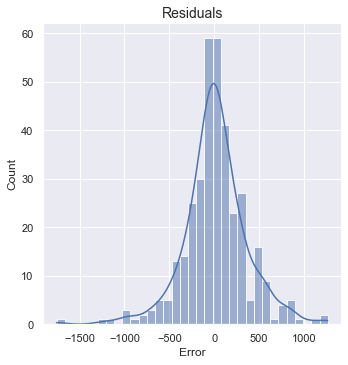

In [15]:
#plotting the error distribution

sb.displot(y_hat_test - y_test, kde=True)
plt.xlabel("Error")
plt.title("Residuals", size=14);

As shown from the above table and plot, random forests and bagging regressors showed better performance than linear model with percent error around 8%. The error is uniformly distributed around zero with slight skewness toward negative values where the model underestimates fluid rate for few tests. Overall, the models showed good performance on sample data and we can move forward to the next step of selecting the important features.

### 4. Selecting important features using three different approaches

Three approaches were used select the most important features affecting the models performance. firstly, the feature importance approach embedded with decision trees model is used, then permutation importance and backward feature selection approaches are used again with the same model to compare the results. The final features are selected based on common features among all three approaches.  

In [16]:
#Embedded Tree Feature Importance

importances_rf = pd.Series(reg_rand.feature_importances_, index = data_sample.columns.drop(columns_to_drop))
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf

Rsb                      0.000090
Reservoir                0.000126
liner size               0.000199
API                      0.001353
TVD\n(top perf.)         0.001894
WC%                      0.007093
Pr                       0.007106
MD\n(top perf.)          0.007674
Pr-Pb                    0.008070
?g                       0.008085
tbg end depth\n(ORKB)    0.008733
WHP                      0.008743
tbg end to top perf.     0.008958
D/S                      0.021273
?w                       0.027935
IG (MMCFD)               0.028865
Tr                       0.044142
tbg type                 0.286824
WHT                      0.522838
dtype: float64

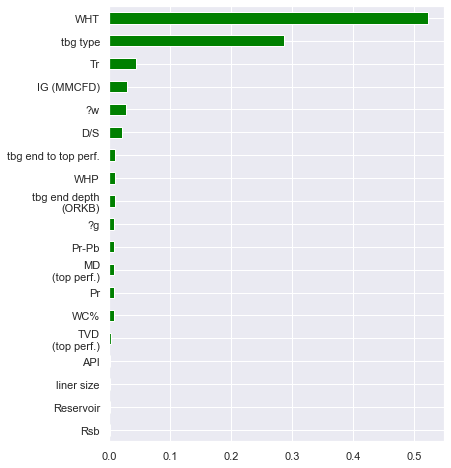

In [17]:
plt.figure(figsize = [6, 8])
sorted_importances_rf.plot(kind='barh', color='green');

In [18]:
#Permutation Importance

result = permutation_importance(estimator=reg_rand, X=x_test, y=y_test, scoring='r2', n_repeats=50, random_state=1)
indices = np.argsort(result['importances_mean'])

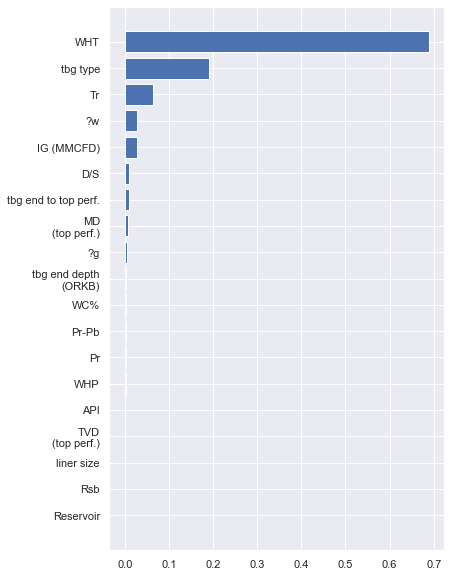

In [19]:
plt.figure(figsize = [6, 10])
plt.barh(inputs.columns[indices], result['importances_mean'][indices]);

In [20]:
#Backward Sequential Selection
sfs = SequentialFeatureSelector(reg_rand, k_features="best", forward=False, floating = False, verbose=0, scoring='r2', n_jobs=-1)
sfs.fit(x_train, y_train)

SequentialFeatureSelector(estimator=RandomForestRegressor(), forward=False,
                          k_features='best', n_jobs=-1, scoring='r2')

In [21]:
sfs.k_feature_names_

('WHT',
 'tbg end depth\n(ORKB)',
 'tbg end to top perf.',
 'MD\n(top perf.)',
 'Tr',
 'Rsb',
 'API',
 '?w',
 '?g',
 'Pr',
 'Pr-Pb',
 'WC%',
 'IG (MMCFD)',
 'tbg type',
 'Reservoir')

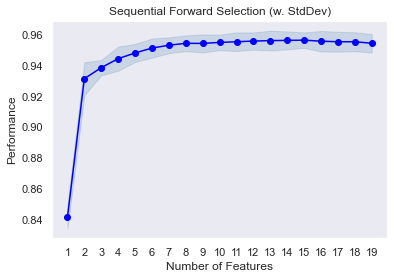

In [22]:
metric_dict = sfs.get_metric_dict(confidence_interval=0.95)

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


fig1 = plot_sfs(metric_dict, kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

Based on the above results, the following features are selected for the uncoming tests:

- Wellhead pressure
- Wellhead temperature
- Reservoir temperature
- Reservoir Pressure
- Water gravity
- difference between reservoir pressure and bubble point
- Watercut percent
- Injection gas
- Downstream pressure
- Tubing type
- Reservoir